In [1]:
import IPython.display as ipd
from matplotlib import pyplot as plt

import torch

from ttsxai.utils.utils import read_ljs_metadata
from ttsxai.utils import plot_utils
from ttsxai.interfaces.tts_interface import TTSInterface, get_text2mel, get_mel2wave

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_dir = '/nas/users/dahye/kw/tts/ttsxai/data/LJSpeech/metadata.csv'
text_dict = read_ljs_metadata(mode='train')

text2mel = get_text2mel('tacotron2', device)
mel2wave = get_mel2wave('waveglow', device)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/nas/users/dahye/kw/tts/ttsxai/src/waveglow/glow.py:74: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2349.)
  W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
/nas/users/dahye/kw/tts/ttsxai/src/tacotron2/stft.py:67: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)


In [5]:
tts = TTSInterface(
    device=device,
    text2mel=text2mel,
    mel2wave=mel2wave 
).to(device)

text = text_dict['LJ001-0002']
# text = 'My name is Kyowoon.'

output_dict = tts.forward(text)
wave = output_dict['wave']

ipd.Audio(wave, rate=tts.sampling_rate)

(80, 167)


In [6]:
print(output_dict)

{'wave': array([-0.00032023, -0.00023853, -0.00012695, ...,  0.00026387,
        0.00027631,  0.0002805 ], dtype=float32), 'mel': array([[-7.138834 , -6.3919616, -6.4443903, ..., -8.503699 , -8.505704 ,
        -8.253587 ],
       [-6.6624084, -5.7936816, -5.5555234, ..., -7.263672 , -7.2968764,
        -7.1946344],
       [-6.067246 , -4.925509 , -4.6459823, ..., -6.1846867, -6.280149 ,
        -6.320035 ],
       ...,
       [-8.441908 , -6.2398725, -5.182501 , ..., -9.5791025, -9.598134 ,
        -9.589606 ],
       [-8.169007 , -5.888784 , -4.897189 , ..., -9.590117 , -9.595144 ,
        -9.590572 ],
       [-8.151357 , -5.893617 , -4.9979224, ..., -9.589846 , -9.593684 ,
        -9.599966 ]], dtype=float32), 'text': 'in being comparatively modern.', 'phone': '{IH0 N} {B IY1 IH0 NG} {K AH0 M P AE1 R AH0 T IH0 V L IY2} {M AA1 D ER0 N}.', 'phonesymbols': ['IH0', 'N', ' ', 'B', 'IY1', 'IH0', 'NG', ' ', 'K', 'AH0', 'M', 'P', 'AE1', 'R', 'AH0', 'T', 'IH0', 'V', 'L', 'IY2', ' ', 'M', 'AA

# Examples of ProsodyInterface

In [14]:
output_dict['mel'].shape

(80, 167)

In [16]:
output_dict['token'].shape

(27,)

In [17]:
from ttsxai.interfaces.prosody_interface import ProsodyInterface
prosody = ProsodyInterface(tts.sampling_rate, tts.hop_length)

# frame level 
out = prosody(wave)
print(out['pitch'].shape) # same as output_dict['mel'].shape[1]

# phone level
out = prosody(wave, duration=output_dict['duration'])
print(out['pitch'].shape) # same as output_dict['token'].shape

(167,)
(27,)


/nas/users/dahye/kw/tts/ttsxai/src/ttsxai/energy_calculator.py:163: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
/nas/users/dahye/kw/tts/ttsxai/src/ttsxai/energy_calculator.py:267: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0, fmax=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  sampling_rate, filter_length, n_mel_channels, mel_fmin, mel_fmax


In [10]:
print(out['pitch'].shape)

(167,)


(0.0, 1.9388662131519274)

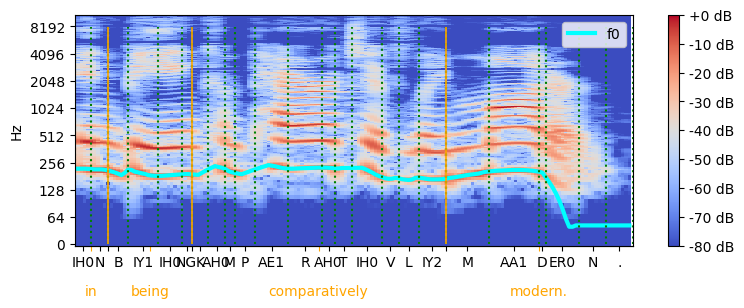

In [18]:
wave = output_dict['wave']
phone = output_dict['phone']
phonesymbols = output_dict['phonesymbols']
token = output_dict['token']
duration = output_dict['duration']
sampling_rate = tts.sampling_rate
hop_length = tts.hop_length

from ttsxai.interfaces.prosody_interface import ProsodyInterface
prosody = ProsodyInterface(sampling_rate, hop_length)
# prosody_dict = prosody(wave, duration)
prosody_dict = prosody(wave)
pitch = prosody_dict['pitch']

fig, ax = plt.subplots(1, 1, figsize=(9, 3))
plot_utils.plot_spectrogram(wave, sr=sampling_rate, hop_length=hop_length, spec_type='spectrogram', ax=ax,
    f0=pitch)
plot_utils.plot_phonesymbols(text, phonesymbols, duration, hop_length, sampling_rate, ax)
# debug
ax.set_xlim([0, len(wave) / sampling_rate])